# Listings

In [195]:
import pandas as pd

df_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/listings.csv.gz', compression='gzip')
df_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/listings.csv.gz', compression='gzip')
df_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/listings.csv.gz', compression='gzip')
df_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/listings.csv.gz', compression='gzip')
df_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/listings.csv.gz', compression='gzip')
df_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/listings.csv.gz', compression='gzip')

df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09, df_2015_10]).drop_duplicates('id')
# df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09]).drop_duplicates('id')
# df_original_listings = pd.concat([df_2020_03, df_2019_18]).drop_duplicates('id')
print('Len total =', len(df_original_listings))

df_listings = df_original_listings.copy()
df_listings = df_listings.replace('nan', '', regex=True)
df_listings['summary'] = df_listings['summary'].astype(str)
df_listings['space'] = df_listings['space'].astype(str)
df_listings['description'] = df_listings['description'].astype(str)
df_listings['neighborhood_overview'] = df_listings['neighborhood_overview'].astype(str)
df_listings['host_neighbourhood'] = df_listings['host_neighbourhood'].astype(str)
df_listings['neighbourhood_cleansed'] = df_listings['neighbourhood_cleansed'].astype(str)
df_listings['notes'] = df_listings['notes'].astype(str)
df_listings['review_scores_rating'] = df_listings['review_scores_rating'].astype(float)
df_listings = df_listings[df_listings['review_scores_rating'].notna()]
print(len(df_listings))
df_listings['review_scores_rating']

Len total = 12480
9684


0        99.0
1        95.0
2        96.0
3        93.0
4        95.0
        ...  
2552     96.0
2554     99.0
2555     99.0
2556    100.0
2557     87.0
Name: review_scores_rating, Length: 9684, dtype: float64

In [196]:
from collections import Counter
from itertools import chain
import itertools
import string
import re
import spacy

# Download the natural language dataset for english, if this is the first run
# !python -m spacy download en_core_web_sm

# Load spacy
nlp = spacy.load('en_core_web_sm')

# Add in common words that occurr in all listings, that really don't mean anything useful here
nlp.Defaults.stop_words |= {'many', 'great', 'nearby', 'short', 'major', 'north', 'south', 'east', 'west', 'easy', 'true', 'local', 'public', 'mi', 'several', 'such', 'main', 'other'}

print('great' in nlp.Defaults.stop_words)

# Creates a Counter of adjectives used in the "neighborhood overview" field of all listings
# within the neighborhood name provided. 
def get_neighborhood_adjectives(name):
  
  # List of the "neighborhood_overview" field for all listings for this neighborhood
  overviews = df_listings.loc[df_listings['neighbourhood_cleansed'] == name]['neighborhood_overview']
  
  list_overviews = '  '.join([overview for overview in overviews])
    
  # Combine all overviews into one, and load it into spacy
  text = nlp(list_overviews)
  
  # Get the adjectives
  adjectives = [token.lemma_ for token in text if token.pos_ == "ADJ" and not token.is_stop]
  
  # Count the adjectives
  counter = Counter(adjectives)
  
  # Remove pronoun forms
  counter.pop('-PRON-', None)
  
  return (len(overviews), counter)

  
# north_end = get_neighborhood_adjectives('North End')
# print('Listings in north end:', north_end[0])
# print('North end is:', north_end[1])

True


In [197]:
# for neighborhood in df_listings['neighbourhood_cleansed'].unique():
#     ads = get_neighborhood_adjectives(neighborhood)
#     print(neighborhood, ':', ads[0])
#     print(neighborhood, 'is:', ads[1].most_common(5))

# Reviews

In [198]:
import pandas as pd

reviews_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/reviews.csv.gz', compression='gzip')
# reviews_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/reviews.csv.gz', compression='gzip')
# reviews_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/reviews.csv.gz', compression='gzip')
# reviews_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/reviews.csv.gz', compression='gzip')
# reviews_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/reviews.csv.gz', compression='gzip')
# reviews_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/reviews.csv.gz', compression='gzip')

df_reviews = pd.concat([reviews_2020_03])
# df_reviews = pd.concat([reviews_2020_03, reviews_2019_18, reviews_2018_10, reviews_2017_10, reviews_2016_09, reviews_2015_10])
df_reviews['comments'] = df_reviews['comments'].astype(str)
print('Len total =', len(df_reviews))

Len total = 154464


# Vibe Factor Calculations

In [199]:
# Load spacy
import spacy
nlp = spacy.load('en_core_web_sm')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Calculates the neighborhood accuracy statistic for a listing
# Neighborhood accuracy is the dot product between the neighborhood description
# and the reviews left for the place. This metric is greatest when the experience
# of the visitors most matched the vibe that was portrayed by the listing.

# Neighborhood accuracy is calculated as the sum of the number of adjectives that appear 
# in both the neighborhood description and in the reviews for a listing,
# weighted by the frequency by which those adjectives occur in all 
# neighborhood descriptions within that neighborhood.

# calc_neighborhood_accuracy(comments_list) takes in a list of strings as the comments
# for that listing. It returns a scalar neighborhood accuracy score.
def calc_neighborhood_accuracy(neighborhood_adjectives, neighborhood_frequencies, comments_list):
  neighborhood_accuracy = 0

  # Comments, excluding punctuation and special characters
  listing_comments = re.sub('[^\w\s]+', '', ' '.join(comments_list)).split()
  
  # Count up the frequencies of these words
  comment_freq = Counter(listing_comments)
  comment_words = list(comment_freq.keys())

  # Dot product time doo doo doo doo doo
  for i in range(len(neighborhood_adjectives)):
    if (neighborhood_adjectives[i] in comment_words):
      neighborhood_accuracy += neighborhood_frequencies[i] * comment_freq[neighborhood_adjectives[i]]

  neighborhood_accuracy /= len(comments_list)

  return neighborhood_accuracy

# Calculates the mean sentiment of all reviews for a listing.
def calc_happiness(comments_list):
#   sentiment_sum = 0
#   sentence_count = 0
  
  all_comments = '  '.join(comments_list)
  
#   tokens = nltk.word_tokenize(all_comments)
#   text = nltk.Text(tokens)

  happiness = analyser.polarity_scores(all_comments)['compound']
  return happiness
  
#   for comment in comments_list:
#     doc = nlp(comment)
#     sentences = [sent.string.strip() for sent in doc.sents]
#     sentence_count += len(sentences)

#     for sentence in sentences:
#       score = analyser.polarity_scores(sentence)
#       sentiment_sum = sentiment_sum + score['compound']
      
#   return sentiment_sum / sentence_count


In [200]:
calc_happiness(['The movie sucked. That cake is the shit!'])

0.3164

# Generate all data

In [201]:
def gen_data():
  vibedict = []
  for neighborhood in df_listings['neighbourhood_cleansed'].unique():

    # Primary adjectives and their frequencies, used by all listings within to describe this neighborhood
    neighborhood_adjectives = get_neighborhood_adjectives(neighborhood)[1]
    adjectives = list(neighborhood_adjectives)
    frequencies = [neighborhood_adjectives[adjective] for adjective in adjectives]

    count = 1
    listings = df_listings.loc[df_listings['neighbourhood_cleansed'] == neighborhood]['id']
    total_num = len(listings)
    print('Calculating vibes for', len(listings), 'listings in', neighborhood)
    # for each listing within this neighborhood
    for listing_id in listings:
      
      # List of comments for that listing
      comments_list = df_reviews.loc[df_reviews['listing_id'] == listing_id]['comments'].tolist()
      num_comments = len(comments_list)
      if num_comments == 0:
        continue

      print('Starting vibe calculation for listing', listing_id, 'with', num_comments, 'comments')
        
      # Neighborhood accuracy metric ("Consistency")
      consistency = calc_neighborhood_accuracy(adjectives, frequencies, comments_list)

      # Average rating ("Enjoyability")
      enjoyability = df_listings.loc[df_listings['id'] == listing_id]['review_scores_rating'].values[0]
      
      # Number of ratings ("Popularity")
      popularity = len(comments_list)
      
      # Average sentiment of reviews ("Happiness")
      happiness = calc_happiness(comments_list)
      
      print('Completed vibes for listing', listing_id, 'with', num_comments, 'comments | #', count, '/', total_num)
      # Add this listing and its metrics to the dictionary
      vibedict.append({'listing_id': listing_id,
                       'lat': df_listings.loc[df_listings['id'] == listing_id]['latitude'].values[0],
                       'lon': df_listings.loc[df_listings['id'] == listing_id]['longitude'].values[0],
                       'enjoyability': enjoyability,
                       'consistency': consistency,
                       'popularity': popularity,
                       'happiness': happiness})
      count = count + 1

  vibetable = pd.DataFrame(columns=['listing_id', 'lat', 'lon', 'enjoyability',  'consistency', 'popularity', 'happiness'])
  vibetable = vibetable.append(vibedict, ignore_index=True)
  return vibetable

In [203]:
vibetable = gen_data()

Calculating vibes for 567 listings in East Boston
Starting vibe calculation for listing 3781 with 16 comments
Completed vibes for listing 3781 with 16 comments | # 1 / 567
Starting vibe calculation for listing 1042420 with 87 comments
Completed vibes for listing 1042420 with 87 comments | # 2 / 567
Starting vibe calculation for listing 3965313 with 91 comments
Completed vibes for listing 3965313 with 91 comments | # 3 / 567
Starting vibe calculation for listing 4315428 with 1 comments
Completed vibes for listing 4315428 with 1 comments | # 4 / 567
Starting vibe calculation for listing 4315439 with 5 comments
Completed vibes for listing 4315439 with 5 comments | # 5 / 567
Starting vibe calculation for listing 4614037 with 171 comments
Completed vibes for listing 4614037 with 171 comments | # 6 / 567
Starting vibe calculation for listing 4810824 with 8 comments
Completed vibes for listing 4810824 with 8 comments | # 7 / 567
Starting vibe calculation for listing 5364137 with 81 comments
C

Completed vibes for listing 22327139 with 292 comments | # 63 / 567
Starting vibe calculation for listing 22327141 with 299 comments
Completed vibes for listing 22327141 with 299 comments | # 64 / 567
Starting vibe calculation for listing 22327142 with 268 comments
Completed vibes for listing 22327142 with 268 comments | # 65 / 567
Starting vibe calculation for listing 22940115 with 151 comments
Completed vibes for listing 22940115 with 151 comments | # 66 / 567
Starting vibe calculation for listing 23004674 with 63 comments
Completed vibes for listing 23004674 with 63 comments | # 67 / 567
Starting vibe calculation for listing 23258400 with 1 comments
Completed vibes for listing 23258400 with 1 comments | # 68 / 567
Starting vibe calculation for listing 23801768 with 1 comments
Completed vibes for listing 23801768 with 1 comments | # 69 / 567
Starting vibe calculation for listing 24809947 with 47 comments
Completed vibes for listing 24809947 with 47 comments | # 70 / 567
Starting vibe

Completed vibes for listing 35420961 with 30 comments | # 127 / 567
Starting vibe calculation for listing 35579707 with 3 comments
Completed vibes for listing 35579707 with 3 comments | # 128 / 567
Starting vibe calculation for listing 35617006 with 30 comments
Completed vibes for listing 35617006 with 30 comments | # 129 / 567
Starting vibe calculation for listing 35689708 with 5 comments
Completed vibes for listing 35689708 with 5 comments | # 130 / 567
Starting vibe calculation for listing 35693019 with 2 comments
Completed vibes for listing 35693019 with 2 comments | # 131 / 567
Starting vibe calculation for listing 35836205 with 28 comments
Completed vibes for listing 35836205 with 28 comments | # 132 / 567
Starting vibe calculation for listing 35932377 with 66 comments
Completed vibes for listing 35932377 with 66 comments | # 133 / 567
Starting vibe calculation for listing 36143286 with 20 comments
Completed vibes for listing 36143286 with 20 comments | # 134 / 567
Starting vibe 

Completed vibes for listing 5526514 with 122 comments | # 30 / 534
Starting vibe calculation for listing 5726867 with 8 comments
Completed vibes for listing 5726867 with 8 comments | # 31 / 534
Starting vibe calculation for listing 6080461 with 94 comments
Completed vibes for listing 6080461 with 94 comments | # 32 / 534
Starting vibe calculation for listing 6576530 with 15 comments
Completed vibes for listing 6576530 with 15 comments | # 33 / 534
Starting vibe calculation for listing 6800522 with 11 comments
Completed vibes for listing 6800522 with 11 comments | # 34 / 534
Starting vibe calculation for listing 6819620 with 5 comments
Completed vibes for listing 6819620 with 5 comments | # 35 / 534
Starting vibe calculation for listing 7093184 with 7 comments
Completed vibes for listing 7093184 with 7 comments | # 36 / 534
Starting vibe calculation for listing 7161203 with 6 comments
Completed vibes for listing 7161203 with 6 comments | # 37 / 534
Starting vibe calculation for listing 

Completed vibes for listing 20819487 with 104 comments | # 93 / 534
Starting vibe calculation for listing 20819948 with 58 comments
Completed vibes for listing 20819948 with 58 comments | # 94 / 534
Starting vibe calculation for listing 20947820 with 55 comments
Completed vibes for listing 20947820 with 55 comments | # 95 / 534
Starting vibe calculation for listing 20960666 with 99 comments
Completed vibes for listing 20960666 with 99 comments | # 96 / 534
Starting vibe calculation for listing 21253564 with 4 comments
Completed vibes for listing 21253564 with 4 comments | # 97 / 534
Starting vibe calculation for listing 21597619 with 75 comments
Completed vibes for listing 21597619 with 75 comments | # 98 / 534
Starting vibe calculation for listing 21597670 with 102 comments
Completed vibes for listing 21597670 with 102 comments | # 99 / 534
Starting vibe calculation for listing 21597878 with 3 comments
Completed vibes for listing 21597878 with 3 comments | # 100 / 534
Starting vibe ca

Completed vibes for listing 33999432 with 44 comments | # 157 / 534
Starting vibe calculation for listing 34020206 with 5 comments
Completed vibes for listing 34020206 with 5 comments | # 158 / 534
Starting vibe calculation for listing 34089487 with 40 comments
Completed vibes for listing 34089487 with 40 comments | # 159 / 534
Starting vibe calculation for listing 34089666 with 41 comments
Completed vibes for listing 34089666 with 41 comments | # 160 / 534
Starting vibe calculation for listing 34089850 with 45 comments
Completed vibes for listing 34089850 with 45 comments | # 161 / 534
Starting vibe calculation for listing 35077924 with 18 comments
Completed vibes for listing 35077924 with 18 comments | # 162 / 534
Starting vibe calculation for listing 35079257 with 10 comments
Completed vibes for listing 35079257 with 10 comments | # 163 / 534
Starting vibe calculation for listing 35080086 with 7 comments
Completed vibes for listing 35080086 with 7 comments | # 164 / 534
Starting vib

Completed vibes for listing 4275846 with 162 comments | # 14 / 631
Starting vibe calculation for listing 4510513 with 45 comments
Completed vibes for listing 4510513 with 45 comments | # 15 / 631
Starting vibe calculation for listing 4523234 with 3 comments
Completed vibes for listing 4523234 with 3 comments | # 16 / 631
Starting vibe calculation for listing 4924009 with 178 comments
Completed vibes for listing 4924009 with 178 comments | # 17 / 631
Starting vibe calculation for listing 6741968 with 257 comments
Completed vibes for listing 6741968 with 257 comments | # 18 / 631
Starting vibe calculation for listing 7054912 with 2 comments
Completed vibes for listing 7054912 with 2 comments | # 19 / 631
Starting vibe calculation for listing 7913309 with 22 comments
Completed vibes for listing 7913309 with 22 comments | # 20 / 631
Starting vibe calculation for listing 10116914 with 4 comments
Completed vibes for listing 10116914 with 4 comments | # 21 / 631
Starting vibe calculation for 

Completed vibes for listing 19823776 with 41 comments | # 78 / 631
Starting vibe calculation for listing 19823907 with 43 comments
Completed vibes for listing 19823907 with 43 comments | # 79 / 631
Starting vibe calculation for listing 19824694 with 66 comments
Completed vibes for listing 19824694 with 66 comments | # 80 / 631
Starting vibe calculation for listing 19827018 with 31 comments
Completed vibes for listing 19827018 with 31 comments | # 81 / 631
Starting vibe calculation for listing 20588785 with 63 comments
Completed vibes for listing 20588785 with 63 comments | # 82 / 631
Starting vibe calculation for listing 20968661 with 71 comments
Completed vibes for listing 20968661 with 71 comments | # 83 / 631
Starting vibe calculation for listing 21010620 with 2 comments
Completed vibes for listing 21010620 with 2 comments | # 84 / 631
Starting vibe calculation for listing 21011223 with 1 comments
Completed vibes for listing 21011223 with 1 comments | # 85 / 631
Starting vibe calcul

Completed vibes for listing 26280557 with 6 comments | # 142 / 631
Starting vibe calculation for listing 26748319 with 22 comments
Completed vibes for listing 26748319 with 22 comments | # 143 / 631
Starting vibe calculation for listing 26759283 with 5 comments
Completed vibes for listing 26759283 with 5 comments | # 144 / 631
Starting vibe calculation for listing 28464083 with 1 comments
Completed vibes for listing 28464083 with 1 comments | # 145 / 631
Starting vibe calculation for listing 28545204 with 2 comments
Completed vibes for listing 28545204 with 2 comments | # 146 / 631
Starting vibe calculation for listing 28545355 with 4 comments
Completed vibes for listing 28545355 with 4 comments | # 147 / 631
Starting vibe calculation for listing 28545531 with 6 comments
Completed vibes for listing 28545531 with 6 comments | # 148 / 631
Starting vibe calculation for listing 28545748 with 4 comments
Completed vibes for listing 28545748 with 4 comments | # 149 / 631
Starting vibe calcula

Completed vibes for listing 33781676 with 24 comments | # 215 / 631
Starting vibe calculation for listing 34279661 with 27 comments
Completed vibes for listing 34279661 with 27 comments | # 216 / 631
Starting vibe calculation for listing 34340991 with 28 comments
Completed vibes for listing 34340991 with 28 comments | # 217 / 631
Starting vibe calculation for listing 34415230 with 2 comments
Completed vibes for listing 34415230 with 2 comments | # 218 / 631
Starting vibe calculation for listing 34709924 with 1 comments
Completed vibes for listing 34709924 with 1 comments | # 219 / 631
Starting vibe calculation for listing 35126534 with 13 comments
Completed vibes for listing 35126534 with 13 comments | # 220 / 631
Starting vibe calculation for listing 35608865 with 3 comments
Completed vibes for listing 35608865 with 3 comments | # 221 / 631
Starting vibe calculation for listing 35610435 with 1 comments
Completed vibes for listing 35610435 with 1 comments | # 222 / 631
Starting vibe ca

Calculating vibes for 758 listings in Back Bay
Starting vibe calculation for listing 10813 with 80 comments
Completed vibes for listing 10813 with 80 comments | # 1 / 758
Starting vibe calculation for listing 22195 with 21 comments
Completed vibes for listing 22195 with 21 comments | # 2 / 758
Starting vibe calculation for listing 1090413 with 166 comments
Completed vibes for listing 1090413 with 166 comments | # 3 / 758
Starting vibe calculation for listing 1090545 with 117 comments
Completed vibes for listing 1090545 with 117 comments | # 4 / 758
Starting vibe calculation for listing 2108738 with 34 comments
Completed vibes for listing 2108738 with 34 comments | # 5 / 758
Starting vibe calculation for listing 2277821 with 169 comments
Completed vibes for listing 2277821 with 169 comments | # 6 / 758
Starting vibe calculation for listing 2701124 with 77 comments
Completed vibes for listing 2701124 with 77 comments | # 7 / 758
Starting vibe calculation for listing 2881388 with 181 comm

Completed vibes for listing 19065836 with 88 comments | # 63 / 758
Starting vibe calculation for listing 19225442 with 9 comments
Completed vibes for listing 19225442 with 9 comments | # 64 / 758
Starting vibe calculation for listing 19338355 with 83 comments
Completed vibes for listing 19338355 with 83 comments | # 65 / 758
Starting vibe calculation for listing 19820827 with 75 comments
Completed vibes for listing 19820827 with 75 comments | # 66 / 758
Starting vibe calculation for listing 20090712 with 93 comments
Completed vibes for listing 20090712 with 93 comments | # 67 / 758
Starting vibe calculation for listing 20635474 with 141 comments
Completed vibes for listing 20635474 with 141 comments | # 68 / 758
Starting vibe calculation for listing 20999140 with 37 comments
Completed vibes for listing 20999140 with 37 comments | # 69 / 758
Starting vibe calculation for listing 21486679 with 89 comments
Completed vibes for listing 21486679 with 89 comments | # 70 / 758
Starting vibe ca

Completed vibes for listing 35916196 with 80 comments | # 128 / 758
Starting vibe calculation for listing 36015644 with 1 comments
Completed vibes for listing 36015644 with 1 comments | # 129 / 758
Starting vibe calculation for listing 36015710 with 2 comments
Completed vibes for listing 36015710 with 2 comments | # 130 / 758
Starting vibe calculation for listing 36015735 with 2 comments
Completed vibes for listing 36015735 with 2 comments | # 131 / 758
Starting vibe calculation for listing 36304071 with 46 comments
Completed vibes for listing 36304071 with 46 comments | # 132 / 758
Starting vibe calculation for listing 36423296 with 2 comments
Completed vibes for listing 36423296 with 2 comments | # 133 / 758
Starting vibe calculation for listing 37115887 with 4 comments
Completed vibes for listing 37115887 with 4 comments | # 134 / 758
Starting vibe calculation for listing 37116546 with 1 comments
Completed vibes for listing 37116546 with 1 comments | # 135 / 758
Starting vibe calcul

Completed vibes for listing 1732804 with 126 comments | # 20 / 894
Starting vibe calculation for listing 1821633 with 210 comments
Completed vibes for listing 1821633 with 210 comments | # 21 / 894
Starting vibe calculation for listing 1944976 with 5 comments
Completed vibes for listing 1944976 with 5 comments | # 22 / 894
Starting vibe calculation for listing 2000797 with 143 comments
Completed vibes for listing 2000797 with 143 comments | # 23 / 894
Starting vibe calculation for listing 2794782 with 56 comments
Completed vibes for listing 2794782 with 56 comments | # 24 / 894
Starting vibe calculation for listing 2811937 with 72 comments
Completed vibes for listing 2811937 with 72 comments | # 25 / 894
Starting vibe calculation for listing 3094942 with 14 comments
Completed vibes for listing 3094942 with 14 comments | # 26 / 894
Starting vibe calculation for listing 3193484 with 7 comments
Completed vibes for listing 3193484 with 7 comments | # 27 / 894
Starting vibe calculation for 

Completed vibes for listing 15256830 with 189 comments | # 84 / 894
Starting vibe calculation for listing 15313517 with 104 comments
Completed vibes for listing 15313517 with 104 comments | # 85 / 894
Starting vibe calculation for listing 15342021 with 88 comments
Completed vibes for listing 15342021 with 88 comments | # 86 / 894
Starting vibe calculation for listing 15521407 with 176 comments
Completed vibes for listing 15521407 with 176 comments | # 87 / 894
Starting vibe calculation for listing 15710997 with 128 comments
Completed vibes for listing 15710997 with 128 comments | # 88 / 894
Starting vibe calculation for listing 15773147 with 11 comments
Completed vibes for listing 15773147 with 11 comments | # 89 / 894
Starting vibe calculation for listing 15821724 with 110 comments
Completed vibes for listing 15821724 with 110 comments | # 90 / 894
Starting vibe calculation for listing 15929108 with 99 comments
Completed vibes for listing 15929108 with 99 comments | # 91 / 894
Startin

Completed vibes for listing 20438938 with 99 comments | # 147 / 894
Starting vibe calculation for listing 20466987 with 72 comments
Completed vibes for listing 20466987 with 72 comments | # 148 / 894
Starting vibe calculation for listing 20590425 with 99 comments
Completed vibes for listing 20590425 with 99 comments | # 149 / 894
Starting vibe calculation for listing 20655696 with 24 comments
Completed vibes for listing 20655696 with 24 comments | # 150 / 894
Starting vibe calculation for listing 20723594 with 96 comments
Completed vibes for listing 20723594 with 96 comments | # 151 / 894
Starting vibe calculation for listing 20758965 with 97 comments
Completed vibes for listing 20758965 with 97 comments | # 152 / 894
Starting vibe calculation for listing 20873112 with 35 comments
Completed vibes for listing 20873112 with 35 comments | # 153 / 894
Starting vibe calculation for listing 21096288 with 6 comments
Completed vibes for listing 21096288 with 6 comments | # 154 / 894
Starting v

Starting vibe calculation for listing 25025114 with 9 comments
Completed vibes for listing 25025114 with 9 comments | # 210 / 894
Starting vibe calculation for listing 25416313 with 7 comments
Completed vibes for listing 25416313 with 7 comments | # 211 / 894
Starting vibe calculation for listing 26012594 with 26 comments
Completed vibes for listing 26012594 with 26 comments | # 212 / 894
Starting vibe calculation for listing 26038867 with 23 comments
Completed vibes for listing 26038867 with 23 comments | # 213 / 894
Starting vibe calculation for listing 26051186 with 19 comments
Completed vibes for listing 26051186 with 19 comments | # 214 / 894
Starting vibe calculation for listing 26052117 with 19 comments
Completed vibes for listing 26052117 with 19 comments | # 215 / 894
Starting vibe calculation for listing 26066073 with 25 comments
Completed vibes for listing 26066073 with 25 comments | # 216 / 894
Starting vibe calculation for listing 26066238 with 13 comments
Completed vibes 

Completed vibes for listing 32427593 with 38 comments | # 276 / 894
Starting vibe calculation for listing 32723746 with 12 comments
Completed vibes for listing 32723746 with 12 comments | # 277 / 894
Starting vibe calculation for listing 32894516 with 47 comments
Completed vibes for listing 32894516 with 47 comments | # 278 / 894
Starting vibe calculation for listing 32895915 with 29 comments
Completed vibes for listing 32895915 with 29 comments | # 279 / 894
Starting vibe calculation for listing 33038623 with 5 comments
Completed vibes for listing 33038623 with 5 comments | # 280 / 894
Starting vibe calculation for listing 33225349 with 77 comments
Completed vibes for listing 33225349 with 77 comments | # 281 / 894
Starting vibe calculation for listing 33317621 with 6 comments
Completed vibes for listing 33317621 with 6 comments | # 282 / 894
Starting vibe calculation for listing 33318392 with 11 comments
Completed vibes for listing 33318392 with 11 comments | # 283 / 894
Starting vib

Starting vibe calculation for listing 40209504 with 9 comments
Completed vibes for listing 40209504 with 9 comments | # 342 / 894
Starting vibe calculation for listing 40266556 with 2 comments
Completed vibes for listing 40266556 with 2 comments | # 343 / 894
Starting vibe calculation for listing 40302103 with 8 comments
Completed vibes for listing 40302103 with 8 comments | # 344 / 894
Starting vibe calculation for listing 40343727 with 1 comments
Completed vibes for listing 40343727 with 1 comments | # 345 / 894
Starting vibe calculation for listing 40344083 with 2 comments
Completed vibes for listing 40344083 with 2 comments | # 346 / 894
Starting vibe calculation for listing 40344334 with 1 comments
Completed vibes for listing 40344334 with 1 comments | # 347 / 894
Starting vibe calculation for listing 40439006 with 1 comments
Completed vibes for listing 40439006 with 1 comments | # 348 / 894
Starting vibe calculation for listing 40577813 with 4 comments
Completed vibes for listing

Completed vibes for listing 5718921 with 111 comments | # 30 / 720
Starting vibe calculation for listing 5768819 with 103 comments
Completed vibes for listing 5768819 with 103 comments | # 31 / 720
Starting vibe calculation for listing 5769127 with 146 comments
Completed vibes for listing 5769127 with 146 comments | # 32 / 720
Starting vibe calculation for listing 5822827 with 5 comments
Completed vibes for listing 5822827 with 5 comments | # 33 / 720
Starting vibe calculation for listing 5976821 with 225 comments
Completed vibes for listing 5976821 with 225 comments | # 34 / 720
Starting vibe calculation for listing 6426364 with 74 comments
Completed vibes for listing 6426364 with 74 comments | # 35 / 720
Starting vibe calculation for listing 6444303 with 202 comments
Completed vibes for listing 6444303 with 202 comments | # 36 / 720
Starting vibe calculation for listing 6758443 with 118 comments
Completed vibes for listing 6758443 with 118 comments | # 37 / 720
Starting vibe calculat

Completed vibes for listing 18213171 with 37 comments | # 94 / 720
Starting vibe calculation for listing 18617002 with 6 comments
Completed vibes for listing 18617002 with 6 comments | # 95 / 720
Starting vibe calculation for listing 18975041 with 3 comments
Completed vibes for listing 18975041 with 3 comments | # 96 / 720
Starting vibe calculation for listing 19220895 with 102 comments
Completed vibes for listing 19220895 with 102 comments | # 97 / 720
Starting vibe calculation for listing 19982161 with 25 comments
Completed vibes for listing 19982161 with 25 comments | # 98 / 720
Starting vibe calculation for listing 20229074 with 49 comments
Completed vibes for listing 20229074 with 49 comments | # 99 / 720
Starting vibe calculation for listing 20248640 with 132 comments
Completed vibes for listing 20248640 with 132 comments | # 100 / 720
Starting vibe calculation for listing 20443029 with 126 comments
Completed vibes for listing 20443029 with 126 comments | # 101 / 720
Starting vib

Completed vibes for listing 29730126 with 38 comments | # 170 / 720
Starting vibe calculation for listing 29731261 with 48 comments
Completed vibes for listing 29731261 with 48 comments | # 171 / 720
Starting vibe calculation for listing 29825154 with 43 comments
Completed vibes for listing 29825154 with 43 comments | # 172 / 720
Starting vibe calculation for listing 30397128 with 1 comments
Completed vibes for listing 30397128 with 1 comments | # 173 / 720
Starting vibe calculation for listing 30560133 with 32 comments
Completed vibes for listing 30560133 with 32 comments | # 174 / 720
Starting vibe calculation for listing 30748392 with 4 comments
Completed vibes for listing 30748392 with 4 comments | # 175 / 720
Starting vibe calculation for listing 30929175 with 39 comments
Completed vibes for listing 30929175 with 39 comments | # 176 / 720
Starting vibe calculation for listing 31272914 with 21 comments
Completed vibes for listing 31272914 with 21 comments | # 177 / 720
Starting vib

Completed vibes for listing 891661 with 407 comments | # 3 / 347
Starting vibe calculation for listing 1220971 with 145 comments
Completed vibes for listing 1220971 with 145 comments | # 4 / 347
Starting vibe calculation for listing 2183058 with 169 comments
Completed vibes for listing 2183058 with 169 comments | # 5 / 347
Starting vibe calculation for listing 2658094 with 143 comments
Completed vibes for listing 2658094 with 143 comments | # 6 / 347
Starting vibe calculation for listing 4089940 with 52 comments
Completed vibes for listing 4089940 with 52 comments | # 7 / 347
Starting vibe calculation for listing 4150640 with 23 comments
Completed vibes for listing 4150640 with 23 comments | # 8 / 347
Starting vibe calculation for listing 4573238 with 154 comments
Completed vibes for listing 4573238 with 154 comments | # 9 / 347
Starting vibe calculation for listing 4573388 with 161 comments
Completed vibes for listing 4573388 with 161 comments | # 10 / 347
Starting vibe calculation fo

Completed vibes for listing 41645764 with 7 comments | # 66 / 347
Starting vibe calculation for listing 42251080 with 2 comments
Completed vibes for listing 42251080 with 2 comments | # 67 / 347
Calculating vibes for 299 listings in Charlestown
Starting vibe calculation for listing 29765 with 93 comments
Completed vibes for listing 29765 with 93 comments | # 1 / 299
Starting vibe calculation for listing 45987 with 130 comments
Completed vibes for listing 45987 with 130 comments | # 2 / 299
Starting vibe calculation for listing 77681 with 54 comments
Completed vibes for listing 77681 with 54 comments | # 3 / 299
Starting vibe calculation for listing 611081 with 35 comments
Completed vibes for listing 611081 with 35 comments | # 4 / 299
Starting vibe calculation for listing 619142 with 168 comments
Completed vibes for listing 619142 with 168 comments | # 5 / 299
Starting vibe calculation for listing 708802 with 374 comments
Completed vibes for listing 708802 with 374 comments | # 6 / 299

Completed vibes for listing 36622810 with 44 comments | # 63 / 299
Starting vibe calculation for listing 36947453 with 39 comments
Completed vibes for listing 36947453 with 39 comments | # 64 / 299
Starting vibe calculation for listing 38931589 with 3 comments
Completed vibes for listing 38931589 with 3 comments | # 65 / 299
Starting vibe calculation for listing 39557276 with 9 comments
Completed vibes for listing 39557276 with 9 comments | # 66 / 299
Calculating vibes for 735 listings in Jamaica Plain
Starting vibe calculation for listing 40601 with 75 comments
Completed vibes for listing 40601 with 75 comments | # 1 / 735
Starting vibe calculation for listing 197727 with 43 comments
Completed vibes for listing 197727 with 43 comments | # 2 / 735
Starting vibe calculation for listing 197972 with 387 comments
Completed vibes for listing 197972 with 387 comments | # 3 / 735
Starting vibe calculation for listing 210097 with 192 comments
Completed vibes for listing 210097 with 192 comment

Completed vibes for listing 8923817 with 24 comments | # 61 / 735
Starting vibe calculation for listing 9349614 with 1 comments
Completed vibes for listing 9349614 with 1 comments | # 62 / 735
Starting vibe calculation for listing 9349646 with 1 comments
Completed vibes for listing 9349646 with 1 comments | # 63 / 735
Starting vibe calculation for listing 9575439 with 62 comments
Completed vibes for listing 9575439 with 62 comments | # 64 / 735
Starting vibe calculation for listing 9971054 with 94 comments
Completed vibes for listing 9971054 with 94 comments | # 65 / 735
Starting vibe calculation for listing 10085431 with 2 comments
Completed vibes for listing 10085431 with 2 comments | # 66 / 735
Starting vibe calculation for listing 10299047 with 43 comments
Completed vibes for listing 10299047 with 43 comments | # 67 / 735
Starting vibe calculation for listing 10494118 with 34 comments
Completed vibes for listing 10494118 with 34 comments | # 68 / 735
Starting vibe calculation for l

Completed vibes for listing 22013980 with 46 comments | # 124 / 735
Starting vibe calculation for listing 22192478 with 69 comments
Completed vibes for listing 22192478 with 69 comments | # 125 / 735
Starting vibe calculation for listing 22847606 with 70 comments
Completed vibes for listing 22847606 with 70 comments | # 126 / 735
Starting vibe calculation for listing 22957253 with 75 comments
Completed vibes for listing 22957253 with 75 comments | # 127 / 735
Starting vibe calculation for listing 23109832 with 1 comments
Completed vibes for listing 23109832 with 1 comments | # 128 / 735
Starting vibe calculation for listing 23429071 with 48 comments
Completed vibes for listing 23429071 with 48 comments | # 129 / 735
Starting vibe calculation for listing 23567704 with 25 comments
Completed vibes for listing 23567704 with 25 comments | # 130 / 735
Starting vibe calculation for listing 23567927 with 30 comments
Completed vibes for listing 23567927 with 30 comments | # 131 / 735
Starting v

Completed vibes for listing 35425876 with 61 comments | # 188 / 735
Starting vibe calculation for listing 35568967 with 3 comments
Completed vibes for listing 35568967 with 3 comments | # 189 / 735
Starting vibe calculation for listing 35602636 with 1 comments
Completed vibes for listing 35602636 with 1 comments | # 190 / 735
Starting vibe calculation for listing 36388582 with 13 comments
Completed vibes for listing 36388582 with 13 comments | # 191 / 735
Starting vibe calculation for listing 36439921 with 3 comments
Completed vibes for listing 36439921 with 3 comments | # 192 / 735
Starting vibe calculation for listing 36518454 with 1 comments
Completed vibes for listing 36518454 with 1 comments | # 193 / 735
Starting vibe calculation for listing 36758550 with 3 comments
Completed vibes for listing 36758550 with 3 comments | # 194 / 735
Starting vibe calculation for listing 37487261 with 9 comments
Completed vibes for listing 37487261 with 9 comments | # 195 / 735
Starting vibe calcul

Completed vibes for listing 12233830 with 133 comments | # 28 / 717
Starting vibe calculation for listing 12253499 with 40 comments
Completed vibes for listing 12253499 with 40 comments | # 29 / 717
Starting vibe calculation for listing 12409042 with 176 comments
Completed vibes for listing 12409042 with 176 comments | # 30 / 717
Starting vibe calculation for listing 12997334 with 9 comments
Completed vibes for listing 12997334 with 9 comments | # 31 / 717
Starting vibe calculation for listing 13327034 with 115 comments
Completed vibes for listing 13327034 with 115 comments | # 32 / 717
Starting vibe calculation for listing 13345701 with 188 comments
Completed vibes for listing 13345701 with 188 comments | # 33 / 717
Starting vibe calculation for listing 13450030 with 119 comments
Completed vibes for listing 13450030 with 119 comments | # 34 / 717
Starting vibe calculation for listing 13515084 with 162 comments
Completed vibes for listing 13515084 with 162 comments | # 35 / 717
Startin

Completed vibes for listing 34212295 with 78 comments | # 91 / 717
Starting vibe calculation for listing 34212710 with 59 comments
Completed vibes for listing 34212710 with 59 comments | # 92 / 717
Starting vibe calculation for listing 34212943 with 64 comments
Completed vibes for listing 34212943 with 64 comments | # 93 / 717
Starting vibe calculation for listing 34356588 with 1 comments
Completed vibes for listing 34356588 with 1 comments | # 94 / 717
Starting vibe calculation for listing 34446608 with 31 comments
Completed vibes for listing 34446608 with 31 comments | # 95 / 717
Starting vibe calculation for listing 35001266 with 73 comments
Completed vibes for listing 35001266 with 73 comments | # 96 / 717
Starting vibe calculation for listing 35547817 with 4 comments
Completed vibes for listing 35547817 with 4 comments | # 97 / 717
Starting vibe calculation for listing 35968526 with 43 comments
Completed vibes for listing 35968526 with 43 comments | # 98 / 717
Starting vibe calcul

Completed vibes for listing 38131802 with 41 comments | # 155 / 717
Starting vibe calculation for listing 38131820 with 37 comments
Completed vibes for listing 38131820 with 37 comments | # 156 / 717
Starting vibe calculation for listing 38131851 with 39 comments
Completed vibes for listing 38131851 with 39 comments | # 157 / 717
Starting vibe calculation for listing 38179248 with 28 comments
Completed vibes for listing 38179248 with 28 comments | # 158 / 717
Starting vibe calculation for listing 38279103 with 1 comments
Completed vibes for listing 38279103 with 1 comments | # 159 / 717
Starting vibe calculation for listing 38391365 with 3 comments
Completed vibes for listing 38391365 with 3 comments | # 160 / 717
Starting vibe calculation for listing 38391507 with 3 comments
Completed vibes for listing 38391507 with 3 comments | # 161 / 717
Starting vibe calculation for listing 38401070 with 4 comments
Completed vibes for listing 38401070 with 4 comments | # 162 / 717
Starting vibe ca

Completed vibes for listing 16894082 with 43 comments | # 41 / 483
Starting vibe calculation for listing 17436077 with 35 comments
Completed vibes for listing 17436077 with 35 comments | # 42 / 483
Starting vibe calculation for listing 17508585 with 2 comments
Completed vibes for listing 17508585 with 2 comments | # 43 / 483
Starting vibe calculation for listing 17553435 with 119 comments
Completed vibes for listing 17553435 with 119 comments | # 44 / 483
Starting vibe calculation for listing 17832598 with 155 comments
Completed vibes for listing 17832598 with 155 comments | # 45 / 483
Starting vibe calculation for listing 18134498 with 121 comments
Completed vibes for listing 18134498 with 121 comments | # 46 / 483
Starting vibe calculation for listing 18193552 with 32 comments
Completed vibes for listing 18193552 with 32 comments | # 47 / 483
Starting vibe calculation for listing 18194203 with 35 comments
Completed vibes for listing 18194203 with 35 comments | # 48 / 483
Starting vib

Completed vibes for listing 30344021 with 51 comments | # 109 / 483
Starting vibe calculation for listing 30523091 with 42 comments
Completed vibes for listing 30523091 with 42 comments | # 110 / 483
Starting vibe calculation for listing 31624092 with 99 comments
Completed vibes for listing 31624092 with 99 comments | # 111 / 483
Starting vibe calculation for listing 32378499 with 53 comments
Completed vibes for listing 32378499 with 53 comments | # 112 / 483
Starting vibe calculation for listing 32516994 with 15 comments
Completed vibes for listing 32516994 with 15 comments | # 113 / 483
Starting vibe calculation for listing 34687806 with 18 comments
Completed vibes for listing 34687806 with 18 comments | # 114 / 483
Starting vibe calculation for listing 34688974 with 19 comments
Completed vibes for listing 34688974 with 19 comments | # 115 / 483
Starting vibe calculation for listing 35580413 with 3 comments
Completed vibes for listing 35580413 with 3 comments | # 116 / 483
Starting v

Completed vibes for listing 36037605 with 53 comments | # 32 / 96
Starting vibe calculation for listing 36037756 with 23 comments
Completed vibes for listing 36037756 with 23 comments | # 33 / 96
Starting vibe calculation for listing 37744884 with 15 comments
Completed vibes for listing 37744884 with 15 comments | # 34 / 96
Starting vibe calculation for listing 37853806 with 12 comments
Completed vibes for listing 37853806 with 12 comments | # 35 / 96
Starting vibe calculation for listing 37889446 with 27 comments
Completed vibes for listing 37889446 with 27 comments | # 36 / 96
Starting vibe calculation for listing 38433315 with 12 comments
Completed vibes for listing 38433315 with 12 comments | # 37 / 96
Starting vibe calculation for listing 38798321 with 20 comments
Completed vibes for listing 38798321 with 20 comments | # 38 / 96
Starting vibe calculation for listing 39004265 with 12 comments
Completed vibes for listing 39004265 with 12 comments | # 39 / 96
Starting vibe calculatio

Completed vibes for listing 13719227 with 6 comments | # 40 / 572
Starting vibe calculation for listing 14460344 with 8 comments
Completed vibes for listing 14460344 with 8 comments | # 41 / 572
Starting vibe calculation for listing 14900386 with 13 comments
Completed vibes for listing 14900386 with 13 comments | # 42 / 572
Starting vibe calculation for listing 15016872 with 114 comments
Completed vibes for listing 15016872 with 114 comments | # 43 / 572
Starting vibe calculation for listing 15041925 with 7 comments
Completed vibes for listing 15041925 with 7 comments | # 44 / 572
Starting vibe calculation for listing 15476718 with 5 comments
Completed vibes for listing 15476718 with 5 comments | # 45 / 572
Starting vibe calculation for listing 16464424 with 2 comments
Completed vibes for listing 16464424 with 2 comments | # 46 / 572
Starting vibe calculation for listing 16514756 with 158 comments
Completed vibes for listing 16514756 with 158 comments | # 47 / 572
Starting vibe calcula

Completed vibes for listing 30065996 with 81 comments | # 103 / 572
Starting vibe calculation for listing 31140376 with 3 comments
Completed vibes for listing 31140376 with 3 comments | # 104 / 572
Starting vibe calculation for listing 31259705 with 26 comments
Completed vibes for listing 31259705 with 26 comments | # 105 / 572
Starting vibe calculation for listing 31459791 with 27 comments
Completed vibes for listing 31459791 with 27 comments | # 106 / 572
Starting vibe calculation for listing 31764659 with 39 comments
Completed vibes for listing 31764659 with 39 comments | # 107 / 572
Starting vibe calculation for listing 32257076 with 7 comments
Completed vibes for listing 32257076 with 7 comments | # 108 / 572
Starting vibe calculation for listing 32309630 with 4 comments
Completed vibes for listing 32309630 with 4 comments | # 109 / 572
Starting vibe calculation for listing 33351298 with 14 comments
Completed vibes for listing 33351298 with 14 comments | # 110 / 572
Starting vibe 

Completed vibes for listing 29218070 with 43 comments | # 29 / 109
Starting vibe calculation for listing 30249816 with 34 comments
Completed vibes for listing 30249816 with 34 comments | # 30 / 109
Starting vibe calculation for listing 32546785 with 7 comments
Completed vibes for listing 32546785 with 7 comments | # 31 / 109
Starting vibe calculation for listing 35407404 with 1 comments
Completed vibes for listing 35407404 with 1 comments | # 32 / 109
Starting vibe calculation for listing 36112527 with 1 comments
Completed vibes for listing 36112527 with 1 comments | # 33 / 109
Calculating vibes for 165 listings in Roslindale
Starting vibe calculation for listing 743759 with 5 comments
Completed vibes for listing 743759 with 5 comments | # 1 / 165
Starting vibe calculation for listing 753446 with 142 comments
Completed vibes for listing 753446 with 142 comments | # 2 / 165
Starting vibe calculation for listing 849408 with 150 comments
Completed vibes for listing 849408 with 150 comment

Completed vibes for listing 36528015 with 40 comments | # 62 / 165
Starting vibe calculation for listing 37461678 with 33 comments
Completed vibes for listing 37461678 with 33 comments | # 63 / 165
Starting vibe calculation for listing 38760215 with 9 comments
Completed vibes for listing 38760215 with 9 comments | # 64 / 165
Starting vibe calculation for listing 38908913 with 1 comments
Completed vibes for listing 38908913 with 1 comments | # 65 / 165
Starting vibe calculation for listing 38923194 with 1 comments
Completed vibes for listing 38923194 with 1 comments | # 66 / 165
Calculating vibes for 471 listings in Beacon Hill
Starting vibe calculation for listing 1055627 with 8 comments
Completed vibes for listing 1055627 with 8 comments | # 1 / 471
Starting vibe calculation for listing 1252489 with 65 comments
Completed vibes for listing 1252489 with 65 comments | # 2 / 471
Starting vibe calculation for listing 1886037 with 1 comments
Completed vibes for listing 1886037 with 1 commen

Completed vibes for listing 18719421 with 39 comments | # 60 / 471
Starting vibe calculation for listing 18934135 with 54 comments
Completed vibes for listing 18934135 with 54 comments | # 61 / 471
Starting vibe calculation for listing 19019562 with 62 comments
Completed vibes for listing 19019562 with 62 comments | # 62 / 471
Starting vibe calculation for listing 19290895 with 48 comments
Completed vibes for listing 19290895 with 48 comments | # 63 / 471
Starting vibe calculation for listing 19291771 with 54 comments
Completed vibes for listing 19291771 with 54 comments | # 64 / 471
Starting vibe calculation for listing 19292171 with 64 comments
Completed vibes for listing 19292171 with 64 comments | # 65 / 471
Starting vibe calculation for listing 19307193 with 64 comments
Completed vibes for listing 19307193 with 64 comments | # 66 / 471
Starting vibe calculation for listing 19308245 with 49 comments
Completed vibes for listing 19308245 with 49 comments | # 67 / 471
Starting vibe ca

Completed vibes for listing 20771314 with 50 comments | # 18 / 273
Starting vibe calculation for listing 21798943 with 47 comments
Completed vibes for listing 21798943 with 47 comments | # 19 / 273
Starting vibe calculation for listing 21861361 with 34 comments
Completed vibes for listing 21861361 with 34 comments | # 20 / 273
Starting vibe calculation for listing 21861781 with 41 comments
Completed vibes for listing 21861781 with 41 comments | # 21 / 273
Starting vibe calculation for listing 21861961 with 34 comments
Completed vibes for listing 21861961 with 34 comments | # 22 / 273
Starting vibe calculation for listing 21862054 with 27 comments
Completed vibes for listing 21862054 with 27 comments | # 23 / 273
Starting vibe calculation for listing 21862176 with 33 comments
Completed vibes for listing 21862176 with 33 comments | # 24 / 273
Starting vibe calculation for listing 22161060 with 1 comments
Completed vibes for listing 22161060 with 1 comments | # 25 / 273
Starting vibe calc

Completed vibes for listing 38485772 with 1 comments | # 84 / 273
Starting vibe calculation for listing 39632515 with 1 comments
Completed vibes for listing 39632515 with 1 comments | # 85 / 273
Starting vibe calculation for listing 39633774 with 1 comments
Completed vibes for listing 39633774 with 1 comments | # 86 / 273
Starting vibe calculation for listing 39634292 with 2 comments
Completed vibes for listing 39634292 with 2 comments | # 87 / 273
Starting vibe calculation for listing 40085269 with 5 comments
Completed vibes for listing 40085269 with 5 comments | # 88 / 273
Starting vibe calculation for listing 41707452 with 4 comments
Completed vibes for listing 41707452 with 4 comments | # 89 / 273
Starting vibe calculation for listing 41707872 with 3 comments
Completed vibes for listing 41707872 with 3 comments | # 90 / 273
Starting vibe calculation for listing 41708314 with 3 comments
Completed vibes for listing 41708314 with 3 comments | # 91 / 273
Starting vibe calculation for l

Completed vibes for listing 9448243 with 38 comments | # 33 / 595
Starting vibe calculation for listing 9541295 with 42 comments
Completed vibes for listing 9541295 with 42 comments | # 34 / 595
Starting vibe calculation for listing 10241577 with 2 comments
Completed vibes for listing 10241577 with 2 comments | # 35 / 595
Starting vibe calculation for listing 11240774 with 14 comments
Completed vibes for listing 11240774 with 14 comments | # 36 / 595
Starting vibe calculation for listing 11431331 with 46 comments
Completed vibes for listing 11431331 with 46 comments | # 37 / 595
Starting vibe calculation for listing 11592154 with 2 comments
Completed vibes for listing 11592154 with 2 comments | # 38 / 595
Starting vibe calculation for listing 12246137 with 1 comments
Completed vibes for listing 12246137 with 1 comments | # 39 / 595
Starting vibe calculation for listing 12247217 with 5 comments
Completed vibes for listing 12247217 with 5 comments | # 40 / 595
Starting vibe calculation f

Completed vibes for listing 23413937 with 8 comments | # 103 / 595
Starting vibe calculation for listing 23418172 with 6 comments
Completed vibes for listing 23418172 with 6 comments | # 104 / 595
Starting vibe calculation for listing 23452923 with 40 comments
Completed vibes for listing 23452923 with 40 comments | # 105 / 595
Starting vibe calculation for listing 23454978 with 56 comments
Completed vibes for listing 23454978 with 56 comments | # 106 / 595
Starting vibe calculation for listing 23455311 with 31 comments
Completed vibes for listing 23455311 with 31 comments | # 107 / 595
Starting vibe calculation for listing 23466425 with 33 comments
Completed vibes for listing 23466425 with 33 comments | # 108 / 595
Starting vibe calculation for listing 23467213 with 28 comments
Completed vibes for listing 23467213 with 28 comments | # 109 / 595
Starting vibe calculation for listing 23487192 with 28 comments
Completed vibes for listing 23487192 with 28 comments | # 110 / 595
Starting vi

Completed vibes for listing 8774600 with 154 comments | # 12 / 156
Starting vibe calculation for listing 9494772 with 163 comments
Completed vibes for listing 9494772 with 163 comments | # 13 / 156
Starting vibe calculation for listing 10051649 with 1 comments
Completed vibes for listing 10051649 with 1 comments | # 14 / 156
Starting vibe calculation for listing 10118091 with 4 comments
Completed vibes for listing 10118091 with 4 comments | # 15 / 156
Starting vibe calculation for listing 10118379 with 3 comments
Completed vibes for listing 10118379 with 3 comments | # 16 / 156
Starting vibe calculation for listing 10118716 with 5 comments
Completed vibes for listing 10118716 with 5 comments | # 17 / 156
Starting vibe calculation for listing 10119193 with 12 comments
Completed vibes for listing 10119193 with 12 comments | # 18 / 156
Starting vibe calculation for listing 14216000 with 3 comments
Completed vibes for listing 14216000 with 3 comments | # 19 / 156
Starting vibe calculation 

Completed vibes for listing 13081090 with 46 comments | # 17 / 193
Starting vibe calculation for listing 14995433 with 7 comments
Completed vibes for listing 14995433 with 7 comments | # 18 / 193
Starting vibe calculation for listing 15543038 with 42 comments
Completed vibes for listing 15543038 with 42 comments | # 19 / 193
Starting vibe calculation for listing 15630129 with 112 comments
Completed vibes for listing 15630129 with 112 comments | # 20 / 193
Starting vibe calculation for listing 17559493 with 145 comments
Completed vibes for listing 17559493 with 145 comments | # 21 / 193
Starting vibe calculation for listing 17559756 with 121 comments
Completed vibes for listing 17559756 with 121 comments | # 22 / 193
Starting vibe calculation for listing 17559846 with 205 comments
Completed vibes for listing 17559846 with 205 comments | # 23 / 193
Starting vibe calculation for listing 17573922 with 139 comments
Completed vibes for listing 17573922 with 139 comments | # 24 / 193
Starting

Completed vibes for listing 20094965 with 99 comments | # 18 / 86
Starting vibe calculation for listing 20634420 with 39 comments
Completed vibes for listing 20634420 with 39 comments | # 19 / 86
Starting vibe calculation for listing 20744881 with 79 comments
Completed vibes for listing 20744881 with 79 comments | # 20 / 86
Starting vibe calculation for listing 21477647 with 130 comments
Completed vibes for listing 21477647 with 130 comments | # 21 / 86
Starting vibe calculation for listing 21683291 with 28 comments
Completed vibes for listing 21683291 with 28 comments | # 22 / 86
Starting vibe calculation for listing 21924790 with 152 comments
Completed vibes for listing 21924790 with 152 comments | # 23 / 86
Starting vibe calculation for listing 23027286 with 1 comments
Completed vibes for listing 23027286 with 1 comments | # 24 / 86
Starting vibe calculation for listing 23027875 with 1 comments
Completed vibes for listing 23027875 with 1 comments | # 25 / 86
Starting vibe calculatio

Completed vibes for listing 37209442 with 13 comments | # 34 / 86
Starting vibe calculation for listing 38730599 with 3 comments
Completed vibes for listing 38730599 with 3 comments | # 35 / 86
Starting vibe calculation for listing 39202885 with 1 comments
Completed vibes for listing 39202885 with 1 comments | # 36 / 86
Starting vibe calculation for listing 42239298 with 1 comments
Completed vibes for listing 42239298 with 1 comments | # 37 / 86
Calculating vibes for 16 listings in Leather District
Starting vibe calculation for listing 8014683 with 2 comments
Completed vibes for listing 8014683 with 2 comments | # 1 / 16
Starting vibe calculation for listing 13657486 with 4 comments
Completed vibes for listing 13657486 with 4 comments | # 2 / 16
Starting vibe calculation for listing 35988307 with 13 comments
Completed vibes for listing 35988307 with 13 comments | # 3 / 16
Calculating vibes for 21 listings in Longwood Medical Area
Starting vibe calculation for listing 23147024 with 26 c

In [209]:
import numpy as np

scaled_table = vibetable.copy()

scaled_table['consistency'] = (vibetable['consistency'] - np.quantile(vibetable['consistency'], 0.01)).clip(lower=0)
scaled_table['consistency'] = (scaled_table['consistency'] / np.quantile(scaled_table['consistency'], 0.99)).clip(upper=1)

scaled_table['popularity'] = (vibetable['popularity'] - np.quantile(vibetable['popularity'], 0.0000001)).clip(lower=0)
scaled_table['popularity'] = (scaled_table['popularity'] / np.quantile(scaled_table['popularity'], 0.99)).clip(upper=1)

scaled_table['enjoyability'] = (vibetable['enjoyability'] - np.quantile(vibetable['enjoyability'], 0.01)).clip(lower=0)
scaled_table['enjoyability'] = scaled_table['enjoyability'] / np.amax(scaled_table['enjoyability'])

scaled_table['happiness'] = (vibetable['happiness'] - np.quantile(vibetable['happiness'], 0.01)).clip(lower=0)
scaled_table['happiness'] = scaled_table['happiness'] / np.amax(scaled_table['happiness'])


In [205]:
scaled_table.to_csv("dist/data/vibetable.csv", index=False)
scaled_table.to_json("dist/data/vibetable.json", orient='index')

(array([4.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 8.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        0.000e+00, 1.500e+01, 9.000e+00, 4.000e+00, 3.000e+00, 1.200e+01,
        5.000e+00, 7.000e+00, 6.000e+00, 9.000e+00, 1.200e+01, 1.500e+01,
        1.700e+01, 2.300e+01, 2.100e+01, 2.200e+01, 3.000e+01, 6.700e+01,
        1.020e+02, 2.522e+03]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects

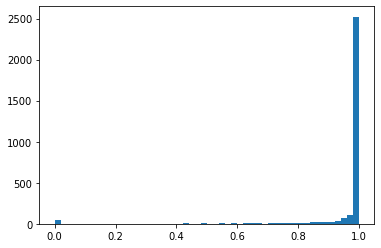

In [210]:
import matplotlib.pyplot as plt
# plt.hist(scaled_table['enjoyability'], bins=50)
# plt.show()
plt.hist(scaled_table['happiness'], bins=50)

In [207]:
vibetable.to_json("dist/data/original_vibetable.json", orient='index')